In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

# Parameters ###################################################################

max_firing_rate = 5         # (per second)
mean_firing_threshold = 0.5 # [Theta] (mV), half of the maximum response of the pop

# Sigmoid slopes (mV^-1) 
r_0 = 0.56
r_1 = 0.56
r_2 = 0.56

# Inverse time constants (s^-1)
a = 100 # excitatory 
ad = 50 # long-range excitatory
b = 50  # inhibitory

# Maximum amplitudes of post-synaptic potential (PSPs) (mV)
A = 3.25 # excitatory
B = 22.0 # inhibitory

# Connectivity constants
C = 135         # Global synaptic connectivity
C1 = C          # Connectivity between Pyramidal and Excitatory
C2 = 0.8 * C    # Connectivity between Excitatory and Pyramidal
C3 = 0.25 * C   # Connectivity between Pyramidal and Inhibitory
C4 = 0.25 * C   # Connectivity between Inhibitory and Pyramidal

# Modified Jansen & Rit Parameters 
# Cholinergic modulation of inhibitory circuits and the segregation/integration balance

# Both as multiples of C
alpha = 0 # excitatory gain, connectivity between long-range pyramidal 
beta = 0  # inhibitory gain, connectibity between inhibitory and excitatory interneuron (short range)

# Structural Connectivity Matrix
num_nodes = 100
SC = np.genfromtxt('SC_in_Schaefer-100.csv', delimiter=',')

In [2]:
# Sigmoid Function - transforms the postynaptic potential (PSP) into an average pulse density 
# v is the average psp, r is the slope of the sigmoid function
# def sigmoid(v, r):
#     return max_firing_rate / (1 + np.exp(r * (mean_firing_threshold - v))) # output is num_nodes x 1 

def sigmoid(v,r):
    return 5 / (1 + np.exp(r * (6 - v)))


# PSPs ###################################################################
# t is average pulse density/spike rate 

# Excitatory PSP
def epsp(t):
    if t < 0:
        return 0
    else:
        return A * a * t * np.exp(-a * t)
    
# Inhibitory PSP
def ipsp(t):
    if t < 0:
        return 0
    else:
        return B * b * t * np.exp(-b * t)

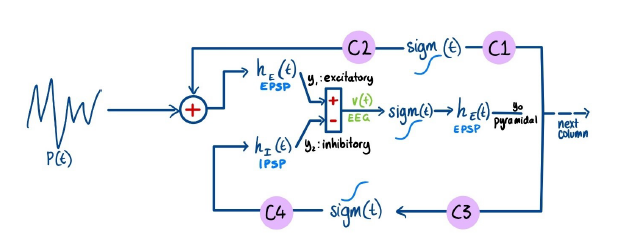

In [17]:
# x3 is a vector of size num_nodes by 1
def calculate_zi(x3):
    return np.dot(SC, x3) # output num_nodes x 1

# System of Equations ########################################################  

norm = np.sqrt(np.sum(SC, axis = 1) * np.sum(SC, axis = 0))
# Expanded Jansen & Rit Model 
def system_of_equations(x):
    x0, y0, x1, y1, x2, y2, x3, y3 = x

    # Noise  - uncorrelated Gaussian-distributed noise with mean 2 and standard deviation 2
    noise = np.random.normal(2,2,num_nodes) # produces a num_nodes x 1 vector 

    dx0dt = y0
    dy0dt = A * a * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * a * y0 - a**2 * x0
    dx1dt = y1
    dy1dt = A * a * (noise + sigmoid(C1 * x0 - C * beta * x2, r_1)) - 2 * a * y1 - a**2 * x1
    dx2dt = y2
    dy2dt = B * b * sigmoid(C3 * x0, r_2) - 2 * b * y2 - b**2 * x2
    dx3dt = y3
    dy3dt = A * ad * (sigmoid(C2 * x1 - C4 * x2 + C * alpha * calculate_zi(x3), r_0)) - 2 * ad * y3 - ad**2 * x3
    return [dx0dt, dy0dt, dx1dt, dy1dt, dx2dt, dy2dt, dx3dt, dy3dt] # num_nodes x 8 matrix output 


# Simulation parameters
dt = 0.001 # Step size
transient = 60  # Simulation duration for stabilizing (with Euler method)
sim_length = 600 # Simulation time points (to plot)
downsample = 4 # Downsample the simulation results

# Fixed downsampling so sampling freq matches empirical EEG (250 Hz)
# Sampling freq = 1 / dt = 1000 Hz
# Downsampling to use = current sampling freq / intended sampling freq = 1000 / 250 = 4

# Initial conditions
initial_conditions = np.ones((8, num_nodes)) * 0.5

total_sims = int(transient + sim_length/ dt)
total_downsampled_sims = int(total_sims / downsample)

# Array to store results
sol = np.zeros((total_downsampled_sims, 8, num_nodes))
sol[0,:,:] = np.copy(initial_conditions) #First set of initial conditions
sol[0] = initial_conditions
y_temp = np.copy(initial_conditions)

# Run simulation using Euler method
for i in range(1, total_sims):
    y_temp += dt * np.array(system_of_equations(y_temp))
    if i % downsample == 0:
        sol[int(i/downsample) - 1] = np.copy(y_temp)

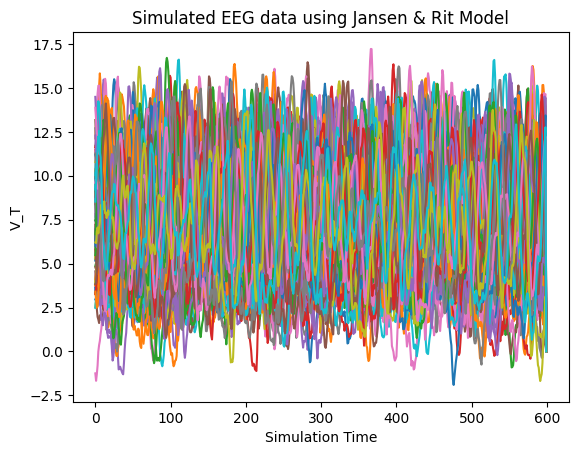

In [32]:
# Plot EEG Results #################################################################
x1 = sol[:, 2]
x2 = sol[:, 4]
x3 = np.apply_along_axis(calculate_zi, axis = 1, arr = sol[:, 6])

# With vectorised operations, calculate for each simulation point
V_T = C2 * x1 - C4 * x2 + C * alpha * x3

# Take final sim_length as simulation results
V_T_plot = V_T[-sim_length:]

# Plot V_T for each node
for node in range(num_nodes):
    plt.plot(V_T_plot[:, node], label=f'Node {node+1}')

plt.xlabel('Simulation Time')
plt.ylabel('V_T')
plt.title('Simulated EEG data using Jansen & Rit Model')

# Add legend to the right of the plot
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

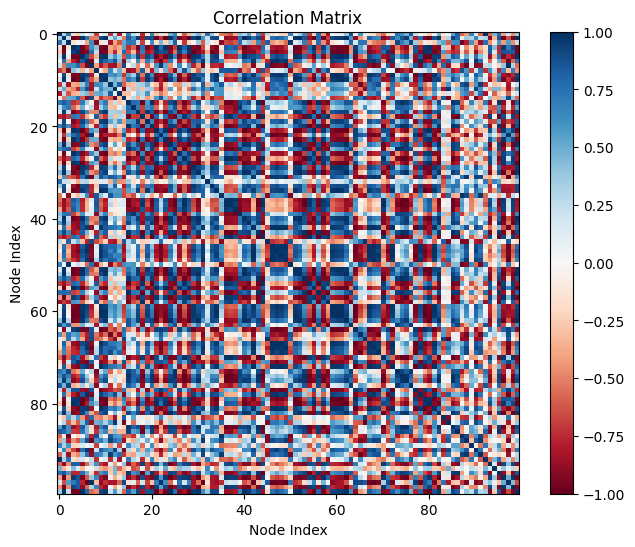

In [44]:
# Balloon-Windkessel Hemodynamic Model #####################################################
# Time Constants
tau_s = 0.65 # Signal decay
tau_f = 0.41 # blood inflow
tau_v = 0.98 # blood volume
tau_q = 0.98 # deoxyhemoglobin content

k = 0.32 # stiffness constant, represents resistance in veins to blood flow
E_0 = 0.4 # resting oxygen extraction rate

# Chosen Constants 
k1 = 2.77
k2 = 0.2
k3 = 0.5

V_0 = 0.03 # fraction of deoxygenated blood in resting state 

# This is from the Neuromod, but had already got firing rates before converted to voltage above, so 
# probably makes more sense to sum x1 x2 x3 (as all need blood)
# Calculate firing rates, V_T is EEG like response, r_0 is the sigmoid slope
firing_rates = sigmoid(V_T, r_0) # sim_length x num_nodes

scaling = 1
# instead of multiplying by arbitrary factor, can standardise - divide by standard deviation, so sd becomes 1

# ODEs for Balloon Windkessel Model
def balloon_windkessel_ode(state, t):
    # s: vasodilatory response
    # f: blood inflow
    # v: blood volume
    # q: deoxyhemoglobin content
    s, f, v, q = state
    
    # NOTE - multiplying firing rate by a large constant
    ds_dt  = scaling * firing_rates[t] - s / tau_s - (f - 1) / tau_f
    df_dt = s
    dv_dt = (f - v**(1/k)) / tau_v
    dq_dt = ((f * (1 - (1 - E_0)**(1 / f))) / E_0 - (q * v**(1/k)) / v) / tau_q
    
    return [ds_dt, df_dt, dv_dt, dq_dt]

# Initial conditions
initial_conditions = np.array([[0.1, 1, 1, 1]] * num_nodes).T

# Array to store results
BOLD_vars = np.zeros((int(total_downsampled_sims / downsample) + 1 , 4, num_nodes))
BOLD_vars[0] = initial_conditions
BOLD_temp = np.copy(initial_conditions)

# Run simulation using Euler method, NOTE - total_downsampled_sims is the number of timepoints we have firing rates for 
for i in range(total_downsampled_sims):
    BOLD_temp += dt * np.array(balloon_windkessel_ode(BOLD_temp, i))
    if i % downsample == 0:
        # print(int(i/downsample), BOLD_temp[0][25], BOLD_temp[1][25], BOLD_temp[2][25], BOLD_temp[3][25])
        BOLD_vars[int(i/downsample)] = np.copy(BOLD_temp)

BOLD_vars_result = BOLD_vars[-sim_length:]
# Initialize BOLD array - will only take the final sim_length timepoints
BOLD_array = np.zeros((sim_length, num_nodes))


# Generate BOLD array
for t in range(sim_length):
    q = BOLD_vars_result[t, 3, :]
    v = BOLD_vars_result[t, 2, :]
    BOLD_array[t, :] = V_0 * (k1 * (1 - q) + k2 * (1 - (q/v)) + k3 * (1 - v))

# Now have a sim_lengthx100 BOLD array stored in BOLD_array
# Calculate the FC from the BOLD signal

FC_matrix = np.corrcoef(BOLD_array.T)

plt.figure(figsize=(8, 6))
plt.imshow(FC_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [46]:
# Calculate goodness of fit for BOLD data ####################################################

# Load the empricical (averaged) FC matrix
observed_fc_matrix = np.load("fc_matrices/averaged_fc_matrix.npy")

# Flatten both and use pearson correlation to calculate goodness of fit
pearson_corr = np.corrcoef(np.ravel(FC_matrix), np.ravel(observed_fc_matrix))[0, 1]

print("Pearson correlation coefficient:", pearson_corr)


Pearson correlation coefficient: 0.03955286734038767


Extracting EDF parameters from c:\Users\stapl\Documents\CDocuments\FinalYearProject\Model\eeg_sample_data\h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp2, F8, T4, T6, O2, Fp1, F7, T3, T5, O1, F4, C4, P4, F3, C3, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2003-06-23 16:14:37 UTC
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
 subject_info: 1 item (dict)
>


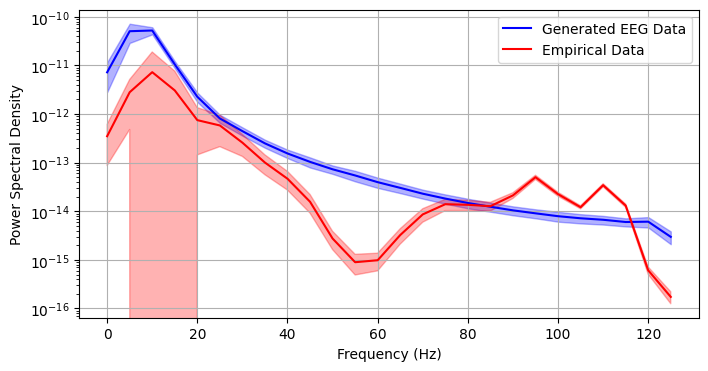

Pearson correlation coefficient between generated and empirical PSDs: 0.883330655359224


In [47]:
# Calculate goodness of fit for EEG data ####################################################
from scipy.stats import pearsonr
import mne
from scipy.signal import welch

# Load the EDF file
raw_eeg_file = mne.io.read_raw_edf('eeg_sample_data/h01.edf')
print(raw_eeg_file.info)

# Convert the data to a numpy array
empirical_data = raw_eeg_file.get_data()

# print(V_T_plot.shape) # returns (600, 100) - 600 time points, 100 nodes (brain regions)
# print(empirical_data.shape) # returns (19, 231250) - 19 channels/electrodes with 231250 time points 

# As values in empirical and generated data are very different, scale based on empirical values
# This just makes it look more comparable on the graph
scaling_factor = np.max(empirical_data) / np.max(V_T_plot)
scaled_gen_data = (V_T_plot * scaling_factor).T

freq  = 250
nperseg = 50 # Number of points in output window

# Calculate the Hamming window
window = np.hamming(nperseg)

frequencies = np.fft.rfftfreq(nperseg, d=1/freq)

# Calculate PSD for generated data
psd_gen = np.zeros((scaled_gen_data.shape[0], len(frequencies))) # (100, 26)
for i, channel_data in enumerate(scaled_gen_data): 
    f, power_spectrum = welch(channel_data, fs=freq, window=window, nperseg=nperseg, noverlap=nperseg//2)
    psd_gen[i, :] = power_spectrum

plt.figure(figsize=(8, 4))
plt.semilogy(frequencies, psd_gen.mean(axis=0), label='Generated EEG Data', color='blue')
# Plot with shaded +- 1 standard deviation above and below
plt.fill_between(frequencies, psd_gen.mean(axis=0) - psd_gen.std(axis=0), psd_gen.mean(axis=0) + psd_gen.std(axis=0), alpha=0.3, color='blue')

# Calculate PSD for empirical data
psd_empirical = np.zeros((empirical_data.shape[0], len(frequencies))) # (19, 26)
for i, channel_data in enumerate(empirical_data): 
    # 250 is taken from data source: https://repod.icm.edu.pl/dataset.xhtml?persistentId=doi:10.18150/repod.0107441
    f, power_spectrum = welch(channel_data, fs=freq , window=window, nperseg=nperseg, noverlap=nperseg//2)
    psd_empirical[i, :] = power_spectrum

plt.semilogy(frequencies, psd_empirical.mean(axis=0), label='Empirical Data', color='red')
# Plot with shaded +- 1 standard deviation above and below
plt.fill_between(frequencies, psd_empirical.mean(axis=0) - psd_empirical.std(axis=0), psd_empirical.mean(axis=0) + psd_empirical.std(axis=0), alpha=0.3, color='red')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()

# Compute the Pearson correlation between the PSDs - will compare mean at each 26 frequency points
correlation_coefficient, _ = pearsonr(psd_gen.mean(axis=0), psd_empirical.mean(axis=0))

print("Pearson correlation coefficient between generated and empirical PSDs:", correlation_coefficient)

 - Mapping nodes to 19 electrodes 
 - Combined goodness-of-fit
 - Approaches to parameter fitting
 - Seperating by drug and other demographics
 - Filtering data - known artifact ? 

In [30]:
import mne
from mne.datasets import fetch_fsaverage

info = raw_eeg_file.info 

# Load the template MRIs
fs_dir = fetch_fsaverage(verbose=False) # returns fsAverage directory
subject = 'fsaverage'

# Load the template brain surfaces
trans = mne.read_trans(f"{fs_dir}/bem/{subject}-trans.fif")
src = mne.setup_source_space(subject, spacing='oct6', subjects_dir="C:/Users/stapl/mne_data/MNE-fsaverage-data")
bem = mne.make_bem_solution(mne.read_bem_surfaces(f"{fs_dir}/bem/{subject}-5120-5120-5120-bem.fif"))

# Map the 100-node simulated EEG data to the 19-node montage
fwd = mne.make_forward_solution(info, trans, src, bem, n_jobs=-1)
mapping = mne.compute_source_morph(fwd, 'fsaverage', subject, subjects_dir=fs_dir).apply(V_T_plot.T)

print(mapping)
empirical_data = mapping.dot(V_T_plot.T)
# Load the template MRIs
fs_dir = fetch_fsaverage(verbose=False) # returns fsAverage directory
subject = 'fsaverage'

# Load the template brain surfaces
trans = mne.read_trans(f"{fs_dir}/bem/{subject}-trans.fif")
src = mne.setup_source_space(subject, spacing='oct6', subjects_dir="C:/Users/stapl/mne_data/MNE-fsaverage-data")
bem = mne.make_bem_solution(mne.read_bem_surfaces(f"{fs_dir}/bem/{subject}-5120-5120-5120-bem.fif"))

# # Map the 100-node simulated EEG data to the 19-node montage
# fwd = mne.make_forward_solution(info, trans, src, bem, n_jobs=-1)
# mapping = mne.compute_source_morph(fwd, 'fsaverage', subject, subjects_dir=fs_dir).apply(V_T_plot.T)

# print(mapping)
# empirical_data = mapping.dot(V_T_plot.T)

Setting up the source space with the following parameters:

SUBJECTS_DIR = C:\Users\stapl\mne_data\MNE-fsaverage-data
Subject      = fsaverage
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading C:\Users\stapl\mne_data\MNE-fsaverage-data\fsaverage\surf\lh.white...
Mapping lh fsaverage -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\stapl\mne_data\MNE-fsaverage-data\fsaverage\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/163842 selected to source space (oct = 6)

Loading C:\Users\stapl\mne_data\MNE-fsaverage-data\fsaverage\surf\rh.white...
Mapping rh fsaverage -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\stapl\mne_data\MNE-fsaverage-data\fsaverage\surf\rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/163842 selected to sour

RuntimeError: Missing EEG channel location